# Optical Image Crystal Growth Rate Calculator
This notebook is used to find areal and facet growth rates for single crystals from optical microscopy images. The data is assumed to be h5py files but the functions can be used once images (as 2D float32 arrays), timestamps, and a scale are fed in.

In [ ]:
"""
The following code was developed by:

Edward Saunders, es758@cam.ac.uk
George Lewis, grl31@cam.ac.uk

This notebook contains the driving code for extracting growth rates from optical data sets, and contains an example of how to extract the required data from hyperspectral data sets.
The code was developed for the NanoDTC mini 1 project "A multidimensional investigation into the growth conditions of halide perovskites".

08/02/2022
"""

## Useful imports

In [2]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path
import optical_image_functions as oif
import hyperspectral_image_functions as hsif

## Folder Selection

This is where you specify the location of the files you wish to look at.

In [211]:
# folder = r'C:\Users\es758\University of Cambridge\Alice Dearle - mini1 hyper-perov\example 1 reflection growth 90deg\2 reflection\\'
folder = r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 1 reflection growth\2 reflection\\'
# folder = r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\'
# folder=r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\hyperspectral 70deg\\'
# folder=r'E:\200122\\'

Can inspect the structure of the files by running the below code.

In [3]:
fpaths = oif.get_filepaths(folder)
fpath=fpaths[0]
oif.get_h5py_contents(fpath)

/
/Cube
/Cube/Angle
/Cube/Images
/Cube/Info
/Cube/Info/Camera
	 ['AveragingMode', 'Binning', 'BitDepth', 'CaptorSize', 'CoolerSetPoint', 'DetectorMode', 'GradientOrientation', 'Model', 'Name', 'Orientation', 'PixelSizeNm', 'ReadoutSpeed', 'RoiSize', 'RoiStart', 'SN', 'Shutter', 'Temperature', 'Trigger', 'VerticalFlip']
/Cube/Info/Camera/DynamicProperties
	 ['ROI Mode']
/Cube/Info/Camera/XAxis
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/XAxis/0
	 ['Name']
/Cube/Info/Camera/XAxis/1
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/YAxis
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Camera/YAxis/0
	 ['Name']
/Cube/Info/Camera/YAxis/1
	 ['Coefs', 'Decimals', 'Name', 'Unit']
/Cube/Info/Cube
	 ['AcqMode', 'BroadBand', 'CreationDate', 'LaserNm', 'Name', 'Type']
/Cube/Info/Cube/ZAxis
	 ['Key']
/Cube/Info/Grating
/Cube/Info/Grating/0
	 ['BeamSide', 'FWHM', 'MaxWavelength', 'MinWavelength', 'Name', 'Type']
/Cube/Info/Grating/0/Calibration
	 ['Curve', 'Factor', 'FocalLe

## Image Data Extraction

Extracting images and timestamps using suggested function which truncates series if a large discontinuity in timestamp is detected.

In [212]:
ts, images, pixel_size = oif.get_data_h5py(folder)

Discontinuous time series, data truncated


A slight adjustment is needed for data from the hyperspectral microscope. It is advisable to pick a wavelength at which the edges are highlighted. Set this by changing i.

In [213]:
# i = 17
# # 22 is a good choice for the 60 degree data
# # 17 not bad for 70, try 34

# fpaths = oif.get_filepaths(folder)

# rectified_fpaths = []
# for fpath in fpaths:
#     if fpath[-9:] == "(1)(1).h5":
#         rectified_fpaths.append(fpath)

# images_2D, ts, wavelengths = hsif.extract_h5py_hyperspec_data(rectified_fpaths)

# images = np.array([image.data[i] for image in images_2D])

# # pixel size
# fpath = rectified_fpaths[0]
# pixel_size = oif.get_pixel_size(fpath)
# print("Pixel size is", pixel_size, "µm/pixel")
# print("Length of images is", len(images))
# print("Length of time steps array is", len(ts))
# print("Hyperspectral data wavelength chosen is", wavelengths[i], "nm")

The images can be plotted over time using hypserspy.

In [187]:
%matplotlib qt

# define axes for better labels
time_size, y_size, x_size = images.shape
dt = ts[1]-ts[0]
dicttime = {'size': time_size, 'name':'time', 'units':'s', 'scale':dt, 'offset':0}
dicty = {'size': y_size, 'name':'y', 'units':'µm', 'scale':pixel_size, 'offset':0} # Note y still increases as go down the image
dictx = {'size': x_size, 'name':'x', 'units':'µm', 'scale':pixel_size, 'offset':0}

#image_stack = hs.signals.Signal2D(images, axes =[dicttime, dicty, dictx])
s = hs.signals.Signal2D(images, axes =[dicttime, dicty, dictx])
s.plot(colorbar=False)

## Crystal Area by Contour Extraction
Contour extraction for area estimation assumes a single large crystal growing entirely in the field of view. Be careful of image data containing multiple crystals and those where crystals are partly out of the field of view. This is trickier to use with hyperspectral data sets, use of the manual facet growth rate tool is advised for these images.

### Image Pre-Processing
Should check if working for data set of interest and tailor accordingly.

In [8]:
def get_binary(im):
    """
    Suggested image pre-processing to produce a binary that can get good estimates of crystal area from an image. 
    @param im: a 2D float32 array
    @return binary: a 2D array of uint8 values of 1s and 0s. 
    Pre-processing can heavily influence the quality of the area estimates and should be tailored to specific sets of images.
    Use plotting functions I have made to investigate 
    Things to consider include:
        Changing the order or presence of image pre-processing operations
        Change the size of kernels from the default values suggested in optical_image_functions
        Avoid causing area values to collapse by making the edge around the crystal discontinuous
        Avoid having a binary that effectively has a shell in the outline
    Use https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html as a guide for what some of the operations do.
    Note that some of the image examples may not apply as expected depending on at which stage the operations are applied (e.g. opening base image rather than the threshold or sobel).
    """
    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end binary in this case.
    im1=oif.open_image(im1)
    im1=oif.sobel_2D(im1)
    binary=oif.threshold_image(im1)
    return binary

Check out what pre-processing has done.

In [5]:
# %matplotlib inline
# plt.imshow(get_binary(images[0]))
# plt.show()
# plt.imshow(get_binary(images[10]))
# plt.show()
# plt.imshow(get_binary(images[20]))
# plt.show()
# plt.imshow(get_binary(images[60]))
# plt.show()

Generate full set of processed images.

In [9]:
binary_images=[get_binary(im) for im in images]

View all vs time in hyperspy.

In [439]:
%matplotlib qt

# define axes for better labels
time_size, y_size, x_size = images.shape
dt = ts[1]-ts[0]
dicttime = {'size': time_size, 'name':'time', 'units':'s', 'scale':dt, 'offset':0}
dicty = {'size': y_size, 'name':'y', 'units':'µm', 'scale':pixel_size, 'offset':0} # Note y still increases as go down the image
dictx = {'size': x_size, 'name':'x', 'units':'µm', 'scale':pixel_size, 'offset':0}

#image_stack = hs.signals.Signal2D(images, axes =[dicttime, dicty, dictx])
s = hs.signals.Signal2D(binary_images, axes =[dicttime, dicty, dictx])
s.plot()

### Contour Extraction

In [10]:
contour_sets, area_sets, perim_sets = oif.get_contour_data(binary_images)

From contour data, extract the most suitable data and clean it for growth rate estimation.

In [11]:
def extract_best_contour_data(contour_sets, area_sets, perim_sets):
    """
    Suggested function for extracting the most relevant contour data. Currently just takes the set of data belonging to the contour with the biggest area. The logic being that the largest contour is
    most likely to be around the most interesting crystal growing entirely within the view of the camera. The area was used instead of the permiter as it is more stable.
    @param contour_sets: an array containing sets of contours for each image.
    @param area_sets: an array containing sets (stored in arrays) of areas (floats) corresponding to contours identified in each image.
    @param perim_sets: an array containing sets (stored in arrays) of perimeters (floats) corresponding to contours identified in each image.
    @return best_contours, best_areas, best_perims
    
    Possible future changes:
    - Make more general so can pick out the contour of a single crystal entirely within frame despite other features of the image
    - Throw an error if this isn't possible or a single crystal isn't present
    """
    best_contours = []
    best_areas = []
    best_perims = []
    for i in np.arange(len(contour_sets)):
        criterion = np.max(area_sets[i]) # Just takes the biggest contour
        best_areas.append(criterion)
        j = area_sets[i].index(criterion)
        best_contours.append(contour_sets[i][j])
        best_perims.append(perim_sets[i][j])
    return best_contours, best_areas, best_perims

def clean_area_data(contour_series, area_series, time_series, step_factor=100):
    """
    Suggested function for processing crystal area data before extracting growth rates. It checks if there is a large step change in the crystal being tracked. If the estimate recovers, it replaces the
    faulty data with NaN. If the estimate does not recover by the next entry, it truncates the series in the assumption that the failure is due to the crystal reaching the edge of the field of view which
    causes the contours to freak out a bit.
    @param contour_series: an array of contour data for each time step
    @param area_series: an array of area estimates (floats) for each contour
    @param time_series: an array of timestamps (floats) for each image
    @param step_factor: factor determining the sensitivity of the detector to a step change in area
    @return cleaned_contour_series, cleaned_area_series, cleaned_time_series
    
    Possible future changes:
    - Make more lenient in truncating condition. Justified for now as possible to remove problems with image pre-processing but more flexibility may be useful for larger data sets.
    """
    cleaned_area_series = []
    index_list = np.arange(len(area_series))
    NaNcounter=0 # Counter used to track how many NaNs in total
    for i in index_list:
        if i == 0 or i == index_list[-1]:
            cleaned_area_series.append(area_series[i])
        elif i == 1:
            cleaned_area_series.append(area_series[i])
         # Check if something has gone wrong with area estimate
        elif abs(area_series[i]-cleaned_area_series[i-1]) > step_factor*abs(cleaned_area_series[i-1]-cleaned_area_series[i-2]):
            # Check if area value collapsed probably without recovery, likely due to crystal reaching edge of frame
            if area_series[i+1] < cleaned_area_series[i-1]: # Perhaps it is a bit harsh, but checks by seeing if 2 in a row a problem
                break
            # If next entry is fine, replace with a NaN and move on
            else:
                cleaned_area_series.append(np.NaN)
                NaNcounter += 1
        # If everything is fine, just add the area to the cleaned list
        else:
            cleaned_area_series.append(area_series[i])   
    cleaned_time_series = time_series[:len(cleaned_area_series)]
    cleaned_contour_series = contour_series[:len(cleaned_area_series)]
    print("Area entries which are dodgy:", NaNcounter)
    if NaNcounter > len(cleaned_area_series)*0.33:
            print("More than a third of area data entries in cleaned range are dodgy")
    return cleaned_contour_series, cleaned_area_series, cleaned_time_series

In [12]:
best_contours, best_areas, best_perims = extract_best_contour_data(contour_sets, area_sets, perim_sets)
cleaned_contour_series, cleaned_area_series, cleaned_time_series = clean_area_data(best_contours, best_areas, ts)

Area entries which are dodgy: 0


### Plot and Calculate Growth Rate

Convert area by pixel into better units and calculate growth rates in µm^2/s.

In [13]:
crystal_area_series = np.array(cleaned_area_series)*pixel_size*pixel_size
crystal_time_series = cleaned_time_series
crystal_area_growth_rates = oif.extract_area_growth_rate(crystal_area_series, crystal_time_series) 

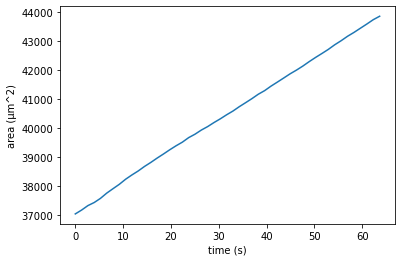

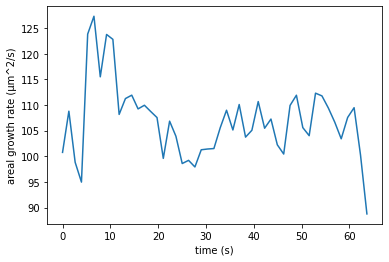

In [14]:
# Could try add to plot marker if NaN, obviously none here rn
%matplotlib inline
plt.figure()
plt.plot(crystal_time_series, crystal_area_series)
plt.xlabel("time (s)")
plt.ylabel("area (µm^2)")
plt.show()
plt.figure()
plt.plot(crystal_time_series, crystal_area_growth_rates)
plt.xlabel("time (s)")
plt.ylabel("areal growth rate (µm^2/s)")
plt.show()

Estimate areal growth rate by linear fit. 

In [15]:
area_g_rate, intercept = oif.fit_speed_linear(crystal_area_series, crystal_time_series, whole_series=True, time_start=0, time_end=0, return_intercept=True)
error = oif.fit_speed_linear_standard_dev(crystal_area_series, crystal_time_series, whole_series=True, time_start=0, time_end=0)
print(area_g_rate, "±",error, "µm^2/s")

106.6900567070083 ± 0.24511108865588774 µm^2/s


In [30]:
%matplotlib qt
plt.figure(dpi=100)
plt.scatter(crystal_time_series, crystal_area_series, alpha =1, marker = "x", s=20, color ="r", label="Crystal Area")

label_text=('2D Growth Rate Fit')
plt.plot(crystal_time_series, area_g_rate*crystal_time_series +intercept, color="g", label=label_text)

plt.xlabel("Time ($s$)", fontsize=10)
plt.ylabel("Area ( $µm^2$)", fontsize=10)
plt.legend(fontsize=10)
plt.show()
print('2D Growth Rate = {0:.2f} '.format(area_g_rate)+('± {0:.2f} '.format(error))+'$µm^2/s$')

2D Growth Rate = 106.69 ± 0.25 $µm^2/s$


### Plots for Pre-Processing Figures

(-0.5, 1023.5, 1023.5, -0.5)

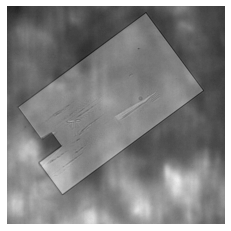

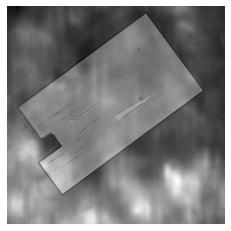

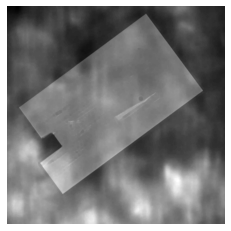

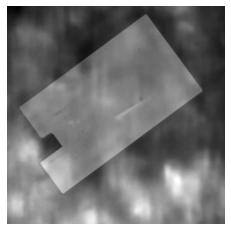

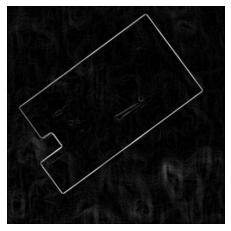

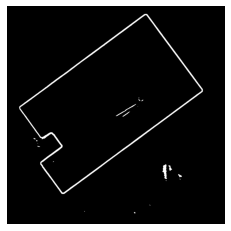

In [214]:
i=0

%matplotlib inline

test_image=images[i]
im1 = oif.blur_image(test_image)
im2=oif.close_image(im1, 8)
im3=oif.open_image(im2)
im4=oif.sobel_2D(im3)
binary=oif.threshold_image(im4)

plt.figure("Original")
plt.imshow(test_image, cmap="gray")
plt.axis("off")

plt.figure("Blurred")
plt.imshow(im1, cmap="gray")
plt.axis("off")

plt.figure("Closed")
plt.imshow(im2, cmap="gray")
plt.axis("off")

plt.figure("Opened")
plt.imshow(im3, cmap="gray")
plt.axis("off")

plt.figure("Sobel Filtered")
plt.imshow(im4, cmap="gray")
plt.axis("off")

plt.figure("Threshold Binary Image")
plt.imshow(binary, cmap="gray")
plt.axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

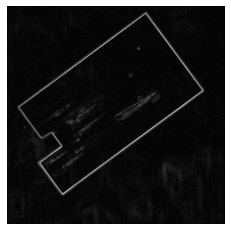

In [215]:
im4=oif.sobel_2D(test_image)
plt.figure("Sobel Filtered Un-processed")
plt.imshow(im4, cmap="gray")
plt.axis("off")


In [25]:
%matplotlib qt

def plot_contours(cnts,im,title=None):
    """ Takes contours and an image, and plots them both"""
    plt.figure()
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=30,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')
    if title != None:
        plt.title(title,fontsize=15)
    #plt.axis('off')
    row, col = im.shape
    plt.xlabel(str(col*pixel_size))
    plt.ylabel(str(row*pixel_size))
    plt.axis("off")
    plt.show()

i=0
plot_contours([cleaned_contour_series[i]],binary_images[i],title=None)

## Facet Growth Rate

Should be fine for crystal not entirely being in frame until a facet grows such that it is out of view.

### Image Pre-Processing

Image pre-processing is again required before facets can be tracked. Pre-processing should be performed to highlight the edges of crystals. However, contours and binaries are not required. Manual selection works on sobel filtered image so it is more obvious what tracking. Have to reference original image if want to see location of other features.

You may wish to view settings saved for previously worked on files to work out how best to perform pre-processing.

In [83]:
x_loaded = np.load('growth vs temperature/pre_processing_90.npy')
x_loaded

array(['\nSaved here are the pre-processing settings that prduced the best quality contours. Print them and copy into pre-processing.\n\n    im1 = oif.blur_image(im)\n    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end binary in this case.\n    im1=oif.open_image(im1)\n    im1=oif.sobel_2D(im1)\n    binary=oif.threshold_image(im1)\n\n'],
      dtype='<U360')

In [216]:
def get_outline(im):
    """
    Suggested image pre-processing to produce an edge contrast enhanced image to be used to extract crysal facet locations from an image. 
    @param im: a 2D float32 array
    @return sobel: a 2D float32 array. 
    Pre-processing can heavily influence the quality of the area estimates and should be tailored to specific sets of images.
    Use plotting functions I have made to investigate 
    Things to consider include:
        Changing the order or presence of image pre-processing operations
        Change the size of kernels from the default values suggested in optical_image_functions
        Avoid causing area values to collapse by making the edge around the crystal discontinuous
        Avoid having a binary that effectively has a shell in the outline
    Use https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html as a guide for what some of the operations do.
    Note that some of the image examples may not apply as expected depending on at which stage the operations are applied (e.g. opening base image rather than the threshold or sobel).
    """
    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end sobel filtered image for the starting data.
    im1=oif.open_image(im1)
    sobel=oif.sobel_2D(im1)
    return sobel

In [217]:
images_copy = images.copy()
outline_images = np.array([get_outline(image) for image in images_copy])

Inspect resulting data.

In [144]:
%matplotlib qt

# define axes for better labels
time_size, y_size, x_size = outline_images.shape
dt = ts[1]-ts[0]
dicttime = {'size': time_size, 'name':'time', 'units':'s', 'scale':dt, 'offset':0}
dicty = {'size': y_size, 'name':'y', 'units':'µm', 'scale':pixel_size, 'offset':0} # Note y still increases as go down the image
dictx = {'size': x_size, 'name':'x', 'units':'µm', 'scale':pixel_size, 'offset':0}

#image_stack = hs.signals.Signal2D(images, axes =[dicttime, dicty, dictx])
s = hs.signals.Signal2D(outline_images, axes =[dicttime, dicty, dictx])
s.plot()

### Manual Facet Growth Rate Extraction

There are some weird sign flips in the functions used here, and in some of the code used for plotting. This might be due to weirdness in the sign convention required for the y axis, or I might just be fighting my own errors. Either way, it works as it is now.

Select pairs of points to define facet tracking lines.

In [204]:
%matplotlib qt

test_image=images[0].copy()+images[-1].copy() # allow final image to be plotted on top so can see where measuring in the end
test_image=get_outline(test_image)
line_points_list=(oif.manual_detection(test_image))
print(len(line_points_list), "facet(s) selected")



2 facet(s) selected


You can also enter in coordinates yourself, or load from a file.

In [153]:
# line_points_list = np.array(

# [[[620.9378366 , 401.14915672],
#         [929.5771286 , 418.36409731]],
#  [[564.37446038, 356.88216664],
#         [572.98193068, 268.34818646]],
#  [[282.78721788, 548.70579035],
#         [209.00890107, 535.1797656 ]]]
    
# )

# 90 degree set

# line_points_list = np.array(
# [[[741.55084142, 206.87554484],
#         [837.60547249, 123.62819791]],
#  [[254.87404399, 833.15173943],
#         [181.87252437, 894.62670331]],
#  [[240.78603143, 591.09406913],
#         [112.71319   , 687.1487002 ]],
#  [[153.69649926, 550.11075987],
#         [ 44.83458404, 626.95446473]],
#  [[335.55993409, 308.05308957],
#         [268.96205654, 217.12137216]],
#  [[587.8634317 , 593.65552596],
#         [692.88316167, 738.37783677]]]
# )

# 70 degree set

# [array([[255.73516838, 465.09036463],
#         [427.88457428, 198.25878549]]),
#  array([[659.05663362, 530.26121115],
#         [501.66289109, 685.19567645]])]

# 60 degree set
# line_points_list = np.array(
#     [[[625.85639106, 407.29734979],
#         [934.49568306, 415.90482009]],
#  [[561.91518315, 371.63783   ],
#         [564.37446038, 254.82216171]],
#  [[295.08360402, 513.04627056],
#         [207.77926246, 501.97952303]]]
# )

Select which facets are going to be included in the plot. This must be compatible with the number of facets chosen.

In [203]:
# set i list going to take forwards somehow that doesn't change position in color.
# I think just replace first len in expressions below to some list of indices I specify here.

i_start = 0
i_end = 1 # inclusive
# i_end = len(line_points_list)
i_list = np.arange(i_start, i_end+1)
i_list

array([0, 1])

Show the positions of the lines over the original image and after a given rotation to display the selection of facets being tracked.

In [208]:
%matplotlib qt
test_image = test_image=images[0].copy()#+images[-1].copy()
test_image = get_outline(test_image)
rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(test_image, line_points_list[0])

rotated_line_points_list = [] # only rotating by the first line for sake of plotting on the same image.

row, col = test_image.shape
image_centre = tuple(np.array([row, col])/2)

for i in i_list:
    line_points = line_points_list[i]
    rotated_points = [oif.rotate_point(image_centre, point, -angle) for point in line_points] # Need -angle for sign convention reasons, it works
    rotated_line_points_list.append(rotated_points)
rotated_line_points_list = np.array(rotated_line_points_list)

plt.figure("Line points original", dpi=300)

plt.imshow((test_image), cmap='Greys_r')

cmap = plt.cm.get_cmap('hsv') # use any colormap you like

for i in i_list:
    col = cmap(i/len(line_points_list)) # cmap takes float between 0 & 1 and returns corresponding color
    line_points = line_points_list[i]
    plt.plot([line_points[0][0],line_points[1][0]], [line_points[0][1], line_points[1][1]], color=col, label="Facet %i" %i, marker = '.', markersize = 10, linestyle='--')
plt.legend(fontsize=8)
plt.axis("off")
plt.show()

plt.figure("Line points rotated")

plt.imshow(rotated_image, cmap='Greys_r')

for i in i_list:
    col = cmap(i/len(line_points_list)) # cmap takes float between 0 & 1 and returns corresponding color
    i_rotated = i-i_list[0] # adjust index for only subset of points being plotted
    rotated_line_points = rotated_line_points_list[i_rotated]
    plt.plot([rotated_line_points[0][0],rotated_line_points[1][0]], [rotated_line_points[0][1], rotated_line_points[1][1]], color=col, label="Facet %i" %i, marker = '.', markersize = 10, linestyle='--')
plt.legend()
plt.axis("off")
plt.show()
    

Track position of facets on lines over all timesteps. If you get an error, it is probably that one of lines selected will be rotated out of frame - something I have yet to fix.

In [206]:
positions_array=[]
error_array = []
for i in np.arange(len(line_points_list)):
    line_points=line_points_list[i]
    positions, error = oif.extract_facet_positions(line_points, outline_images, pixel_size)
    positions_array.append(positions)
    error_array.append(error)
positions_array=np.array(positions_array)
error_array = np.array(error_array)

Plot displacement of facets from their starting position with time. You have to manually extract growth rates from the position data by choosing appropriate time intervals.

In [209]:
%matplotlib qt

cut_time=10000 # sets where truncate data to then fit a linear growth rate

def getnearpos(array,value):
        idx = np.argmin((np.abs(array-value)))
        return idx  
cut_index=getnearpos(ts, cut_time)


growth_info=[]
for i in np.arange(len(line_points_list)):
    name = "Facet %i" %i
    rate = oif.fit_speed_linear(position_array=positions_array[i], time_array=ts, whole_series=False,time_start=0, time_end=cut_time)
    rate=float("{:.3}".format(rate))
    std_dev=oif.fit_speed_linear_standard_dev(position_array=positions_array[i], time_array=ts, whole_series=False,time_start=0, time_end=cut_time)
    std_dev=float("{:.3}".format(std_dev))
    growth_info.append([name, rate, std_dev])

df = pd.DataFrame(growth_info, columns=["Facet", "Growth Rate ($µm/s$)", "Standard Deviation ($µm/s$)"])


plt.figure("Original")
cmap = plt.cm.get_cmap('hsv') # use any colormap you like
for i in i_list:
    col = cmap(i/len(line_points_list)) # cmap takes float between 0 & 1 and returns corresponding color
    plt.plot(ts, positions_array[i], color=col, label="Facet %i" %i)
    plt.fill_between(ts, positions_array[i]-error_array[i], positions_array[i]+error_array[i], color=col, alpha=0.2)
plt.legend()
plt.xlabel("Time ($s$)")
plt.ylabel("Position ($µm$)")
plt.show()

plt.figure("Truncated", dpi=300)
cmap = plt.cm.get_cmap('hsv') # use any colormap you like
for i in i_list:
    col = cmap(i/len(line_points_list)) # cmap takes float between 0 & 1 and returns corresponding color
    plt.scatter(ts[:cut_index], positions_array[i][:cut_index], color=col, s=5)
    plt.plot(ts[:cut_index], positions_array[i][:cut_index], color=col, label="Facet %i" %i)
    plt.fill_between(ts[:cut_index], positions_array[i][:cut_index]-error_array[i][:cut_index], positions_array[i][:cut_index]+error_array[i][:cut_index], color=col, alpha=0.2)
plt.legend(fontsize=10)
plt.xlabel("Time ($s$)", fontsize=10)
plt.ylabel("Position ($µm$)", fontsize=10)
plt.show()

df

,Facet,Growth Rate ($µm/s$),Standard Deviation ($µm/s$)
0,Facet 0,0.0322,0.00183
1,Facet 1,0.0252,0.00145


#### Temperature Investigation

Save values from current investigation.

In [125]:
position_data = np.array([positions_array[0][:cut_index], error_array[0][:cut_index], ts[:cut_index]])
fastest_g_rate = np.array([growth_info[0][1], growth_info[0][2]])
fastest_facet = line_points_list[0]

Remember to change files names.

In [126]:
#growth_data = np.array([crystal_time_series, crystal_area_series])

pre_processing = np.array([
"""
Saved here are the pre-processing settings that prduced the best quality contours. Print them and copy into pre-processing.

    im1 = oif.blur_image(im)
    im1=oif.close_image(im1, 8) # changing the kernel size to 8 was found to improve the end binary in this case.
    im1=oif.open_image(im1)
    im1=oif.sobel_2D(im1)
    binary=oif.threshold_image(im1)
"""
])

### Uncomment if want to save to a different location
# path = Path('~/OneDrive - University Of Cambridge/NanoDTC/Mini 1/Figures/growth vs temperature').expanduser()
# path.mkdir(parents=True, exist_ok=True)
# np.save(path/'growth_data_90', area_growth_data)
# np.save(path/'pre_processing_90', pre_processing)

# np.save('growth vs temperature/growth_data_70', position_data)
# np.save('growth vs temperature/pre_processing_70.npy', pre_processing)
# np.save('growth vs temperature/fastest_growth_rate_70.npy', fastest_g_rate)
# np.save('growth vs temperature/fastest_facet_70.npy', fastest_facet)

In [127]:
[g_60, e_60] =np.load('growth vs temperature/fastest_growth_rate_60.npy')
[g_70, e_70] =np.load('growth vs temperature/fastest_growth_rate_70.npy')
[g_90, e_90] =np.load('growth vs temperature/fastest_growth_rate_90.npy')

In [131]:
%matplotlib qt

temperatures_C = np.array([60, 70, 90])
temperatures_K = temperatures_C + 273.15

growth_rates = np.array([g_60, g_70, g_90])
error = np.array([e_60, e_70, e_90])
ln_error = error/growth_rates # small error approx

plt.figure("Arrhenius", dpi=300)
plt.errorbar((1/temperatures_K),np.log(growth_rates), ln_error, barsabove=True,capsize =5, ls ="none", label="Fastest Facet Growth Rate")
m, c = oif.fit_speed_linear(np.log(growth_rates), 1/temperatures_K, return_intercept=True)
plt.plot(1/temperatures_K, m*(1/temperatures_K)+c, color = "red", ls="--", label= "Arrhenius Fit")


plt.xlabel("1/T ($K^{-1}$)", fontsize = 10)
plt.ylabel("ln(k)", fontsize = 10)
plt.legend(fontsize=10)
#plt.ylabel("Position ($µm$)")
#"$"
plt.show()

In [133]:
Ea = -m*8.31 
print("Ea is", Ea, "J per mol")
std_dev = oif.fit_speed_linear_standard_dev(np.log(growth_rates), 1/temperatures_K)
std_dev = std_dev*8.31
print("Uncertainty is", std_dev, "J per mol")
print("A is", np.exp(c))

Ea is 120713.35953052016 J per mol
Uncertainty is 13753.505752055258 J per mol
A is 8.818691444015019e+16


#### Plotting for Figures

##### Processing demonstration

In [35]:
%matplotlib qt

test_image=images[0].copy()+images[-1].copy() # allow final image to be plotted on top so can see where measuring in the end
test_image=get_outline(test_image)
line_points_list_plot=(oif.manual_detection(test_image))

In [218]:
line_points_list_plot = np.array([[[741.55084142, 206.87554484],[837.60547249, 123.62819791]]])

In [79]:
%matplotlib qt
test_image=images[0].copy()
test_image=get_outline(test_image)
rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(test_image, line_points_list_plot[0])

rotated_line_points_list = [] # only rotating by the first line for sake of plotting on the same image.

row, col = test_image.shape
image_centre = tuple(np.array([row, col])/2)

for line_points in line_points_list_plot:
    rotated_points = [oif.rotate_point(image_centre, point, -angle) for point in line_points] # Need -angle for sign convention reasons, it works
    rotated_line_points_list.append(rotated_points)
rotated_line_points_list = np.array(rotated_line_points_list)

plt.figure("Line points original")

plt.imshow((test_image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(line_points_list_plot)):
    col = cmap(i/len(line_points_list_plot)) # cmap takes float between 0 & 1 and returns corresponding color
    line_points = line_points_list_plot[i]
    plt.plot([line_points[0][0],line_points[1][0]], [line_points[0][1], line_points[1][1]], color=col, label="Facet %i" %i, marker = '.', markersize = 10, linestyle='--')
#plt.legend()
plt.axis("off")
plt.show()

plt.figure("Line points rotated")

plt.imshow(rotated_image, cmap='Greys_r')

for i in np.arange(len(line_points_list_plot)):
    col = cmap(i/len(line_points_list_plot)) # cmap takes float between 0 & 1 and returns corresponding color
    rotated_line_points = rotated_line_points_list[i]
    plt.plot([rotated_line_points[0][0],rotated_line_points[1][0]], [rotated_line_points[0][1], rotated_line_points[1][1]], color=col, label="Facet %i" %i, marker = '.', markersize = 10, linestyle='--')
#plt.legend()
plt.axis("off")
plt.show()

In [219]:
%matplotlib qt

i=0 # which facet want to plot for
t=0 # time step plotting for
first_image=outline_images[t]
rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(first_image, line_points_list_plot[i])
crop_window_width=50
crop_pixel_width=crop_window_width


plt.figure("Cropped image")
rotated_line_points=np.rint(rotated_line_points)
rotated_line_points=rotated_line_points.astype(int)
# define crop coordinates
x_pixel=rotated_line_points[0][0]
y_pixel_0=rotated_line_points[0][1]
y_pixel_1=rotated_line_points[1][1]
# crop
image=rotated_image.copy()
cropped=image[y_pixel_1:y_pixel_0, x_pixel-(crop_pixel_width):x_pixel+(crop_pixel_width)] #way rotation works means should always be in the right order due to direction of arrow
# alignment to force perpendicular tracking
alignment_angle=oif.find_alignment(cropped, 1)
cropped=oif.rotate_image(cropped, alignment_angle)
plt.imshow(cropped, cmap='Greys_r')
plt.axis("off")

plt.show()
print("Angle adjusted by is" , alignment_angle)

plt.figure("1D image of facet")
one_dim_facet, angle_adjustment = oif.extract_line_data(line_points=rotated_line_points, image=rotated_image, crop_pixel_width=crop_window_width, 
                                                    auto_align=True)
position = np.arange(len(one_dim_facet))*pixel_size
position -= position[-1]
position *= -1
plt.plot(position, np.array(one_dim_facet), marker = '.', markersize = 8)
plt.xlabel("Position ($µm$)", fontsize=15)
plt.ylabel("Sobel Signal", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

rotated_image, rotated_line_points, angle = oif.image_rotation_by_manual_line(test_image, line_points_list_plot[0])

rotated_line_points_list = [] # only rotating by the first line for sake of plotting on the same image.

row, col = test_image.shape
image_centre = tuple(np.array([row, col])/2)

for line_points in line_points_list_plot:
    rotated_points = [oif.rotate_point(image_centre, point, -angle) for point in line_points] # Need -angle for sign convention reasons, it works
    rotated_line_points_list.append(rotated_points)
rotated_line_points_list = np.array(rotated_line_points_list)

plt.figure("Line points original")

plt.imshow((first_image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(line_points_list_plot)):
    col = cmap(i/len(line_points_list_plot)) # cmap takes float between 0 & 1 and returns corresponding color
    line_points = line_points_list_plot[i]
    plt.plot([line_points[0][0],line_points[1][0]], [line_points[0][1], line_points[1][1]], color=col, label="Facet %i" %i, marker = '.', markersize = 10, linestyle='--')
#plt.legend()
plt.axis("off")
plt.show()

Angle adjusted by is 4


In [38]:
positions_array=[]
error_array = []
for i in np.arange(len(line_points_list_plot)):
    line_points=line_points_list_plot[i]
    positions, error = oif.extract_facet_positions(line_points, outline_images, pixel_size)
    positions_array.append(positions)
    error_array.append(error)
positions_array_plot=np.array(positions_array)
error_array_plot = np.array(error_array)

In [ ]:
%matplotlib inline

cmap = plt.cm.get_cmap('autumn') # use any colormap you like


for i in np.arange(len(line_points_list_plot)):
    col = cmap(i/len(line_points_list_plot)) # cmap takes float between 0 & 1 and returns corresponding color
    plt.plot(ts, positions_array_plot[i], color=col, label="Facet %i" %i)
    plt.fill_between(ts, positions_array_plot[i]-error_array_plot[i], positions_array_plot[i]+error_array_plot[i], color=col, alpha=0.2)
    

plt.legend()
plt.xlabel("Time ($s$)")
plt.ylabel("Position ($µm$)")



plt.show()

NameError: name 'line_points_list_plot' is not defined

In [40]:
i=0
print(oif.fit_speed_linear(position_array=positions_array_plot[i], time_array=ts, whole_series=False,time_start=0, time_end=105), "µm/s")
print(oif.fit_speed_linear(position_array=positions_array_plot[i], time_array=ts, whole_series=False,time_start=105, time_end=190), "µm/s")

0.09463571125693043 µm/s
0.2398317618924295 µm/s


In [41]:
print(oif.fit_speed_linear_standard_dev(position_array=positions_array_plot[i], time_array=ts, whole_series=False,time_start=0, time_end=105))
print(oif.fit_speed_linear_standard_dev(position_array=positions_array_plot[i], time_array=ts, whole_series=False,time_start=105, time_end=190))

0.0006516112073833054
0.011400234715865083


### Automatic Facet Growth Rate Extraction

Not fully implemented. Could be useful for rapidly extracting some measure of facet growth rate from large data sets. Peak finder implementation may be useful for refining other tools.

#### Find Alignment

First determine a suitable angle to align the image. Observe which facets become prominent in 1D-version of the image.

144 degrees rotation


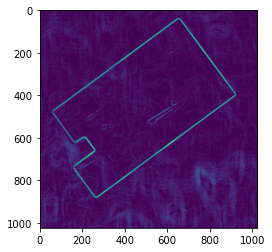

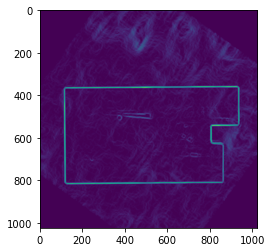

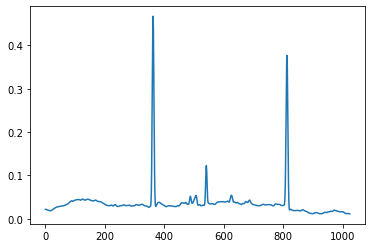

In [96]:
%matplotlib inline
image_test=images[0].copy()
sobel=get_outline(image_test)
angle=find_alignment(sobel, 1)
print(angle, "degrees rotation")
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, angle))
plt.show()
plt.plot(onedimify(rotate_image(sobel, angle)))

Can change by 90 degrees if another face might be more interesting.

54 degrees rotation


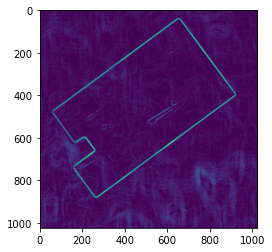

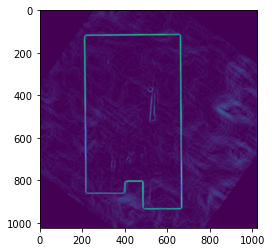

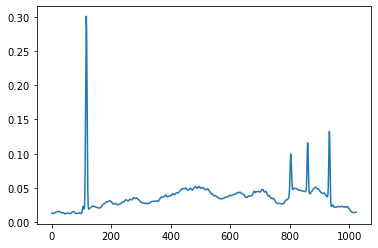

In [97]:
angle_90=angle-90
print(angle_90, "degrees rotation")
plt.imshow(sobel)
plt.show()
plt.imshow(rotate_image(sobel, angle_90))
plt.show()
plt.plot(onedimify(rotate_image(sobel, angle_90)))

#### Check peak finder

Check that the peak finder has suitable parameters for the data set. 

‘slope_thresh’ and ‘amp_thresh’, control sensitivity: higher values will neglect broad peaks (slope) and smaller features (amp), respectively.

peakgroup is the number of points around the top of the peak that are taken to estimate the peak height. For spikes or very narrow peaks, set peakgroup to 1 or 2; for broad or noisy peaks, make peakgroup larger to reduce the effect of noise.

  0%|          | 0/1 [00:00<?, ?it/s]

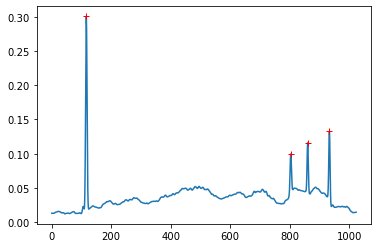

[116.0, 803.0, 860.0, 933.0]


In [100]:
#onedimified_image=onedimify(rotate_image(sobel, angle))
onedimified_image=onedimify(rotate_image(sobel, angle_90))

coordinates = np.arange(len(onedimified_image))
coordinates_micrometres = coordinates*pixel_size

%matplotlib inline

a= onedimified_image

s = hs.signals.Signal1D(a)
peaks = s.find_peaks1D_ohaver(peakgroup=2,slope_thresh=0.001, amp_thresh=None) # not sure if xdim is doing anything or I have implemented right as positions still to be in index
# and therefore pixel rather than distance.

plt.plot(a)
position = [i[0] for i in peaks[0]]
height = [i[1] for i in peaks[0]]
plt.plot(position, height, 'r+')
plt.show()

print(position)

#### Extract

Currently just takes maximum peak position but could be expanded.

In [90]:
rotated_images = []
onedimified_images=[]
for im in images:
    sobel=get_outline(im)
    rot_sobel = rotate_image(sobel, angle)
    onedimified_images.append(onedimify(rot_sobel))
    rotated_images.append(rot_sobel)
print("done")

done


In [91]:
%matplotlib qt
s = hs.signals.Signal2D(rotated_images)
s.plot()

In [28]:
%matplotlib qt
onedim = hs.signals.Signal1D(onedimified_images)
onedim.plot()

In [61]:
%%capture 
# Just here to stop the output being spammed with progress bars for each time step.



max_heights = []
max_positions = []

coordinates = np.arange(len(onedimified_images[0]))
coordinates_micrometres = coordinates*pixel_size

for Onedim_Im in onedimified_images:
    s = hs.signals.Signal1D(Onedim_Im)
    peaks = s.find_peaks1D_ohaver(xdim = coordinates_micrometres, peakgroup=2,slope_thresh=0.001) # parameters should be tested before using for a dataset
    positions = [i[0] for i in peaks[0]] # Note that is by pixel index
    heights = [i[1] for i in peaks[0]] # Will be stronger for a larger facet
    max_height = np.max(heights)
    max_heights.append(max_height)
    max_position = positions[heights.index(max_height)]
    max_positions.append((max_position+0.5)*pixel_size) # not a perfect conversion but sets position by midpoint of pixel

In [206]:
max_heights = np.array(max_heights)
max_positions = np.array(max_positions)
max_positions -= max_positions[0]
max_positions *= -1
ts=np.array(ts)

In [207]:
max_positions.shape

(110,)

Text(0, 0.5, 'position (µm)')

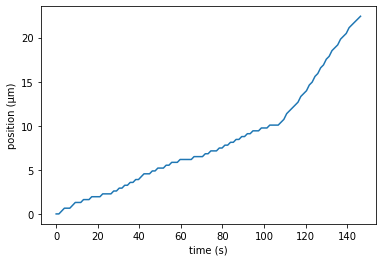

In [208]:
plt.plot(ts, max_positions)
plt.xlabel("time (s)")
plt.ylabel("position (µm)")

In [221]:
print(fit_speed_linear(max_positions, ts, whole_series=False, time_start=0, time_end=110), "µm/s")

0.09514838730099018 µm/s


Got to be careful of facet growing off screen. Don't think that happens in my example data but I will make sure.

In [33]:
for i in max_positions:
    if i == pixel_size*0.5:
        print("reached extent")
    if i == pixel_size*(-0.5+len(onedimified_images[0])):
        print("reached extent")

Instantaneous growth rate. Perhaps not very useful on its own but could be used to expand automatic growth rate.

Text(0, 0.5, 'facet growth rate (µm/s)')

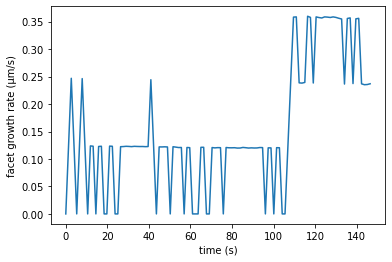

In [34]:
%matplotlib inline

facet_growth_rates=[]

for i in np.arange(len(max_positions)):
    if i == 0:
        gro = (max_positions[1]-max_positions[0])/(ts[1]-ts[0])
    elif i == len(max_positions)-1:
        gro = (max_positions[-1]-max_positions[-2])/(ts[-1]-ts[-2])
    else:
        gro = (max_positions[i+1]-max_positions[i-1])/(ts[i+1]-ts[i-1])
    facet_growth_rates.append(abs(gro))
    
plt.plot(ts, facet_growth_rates)
plt.xlabel("time (s)")
plt.ylabel("facet growth rate (µm/s)")